In [1]:
import numpy as np
from TMDP import TMDP
from River_swim import River

from algorithms import *
from model_functions import *
import matplotlib as mpl
import matplotlib.pyplot as plt

np.set_printoptions(precision=4)
import math
from utils import *

In [2]:
# Test with tau=0.9
nS = 8
nA = 2
seed = 3231
status_step = 100
gamma = 0.9
river = River(nS, gamma, 5, 1000)
tau = 0.3
xi = np.ones(river.nS)*1/river.nS
tmdp = TMDP(river, xi, tau, gamma, seed)
tmdp_0 = TMDP(river, xi, 0, gamma, seed)

In [3]:
# Optimal Q function
r_s_a = compute_r_s_a(tmdp.nS, tmdp.nA, tmdp.P_mat, tmdp.reward)
Q_star = bellman_optimal_q(tmdp.nS, tmdp.nA, tmdp.P_mat, tmdp.reward, 1e-4, gamma)
J_star = get_expected_avg_reward(tmdp.P_mat, get_policy(Q_star), tmdp.reward, tmdp.gamma, tmdp.mu)
delta_q = np.linalg.norm(Q_star - Q_star, np.inf)

In [4]:
#taus = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01, 0]
results = []
intermediate_results = {}
curr_j = []
delta_qs = []

Q = np.zeros((tmdp.nS, tmdp.nA))
M = 200000

s = tmdp.reset()
a = eps_greedy(s, Q, 1., tmdp.allowed_actions[s.item()])

Q, inner_J, inner_delta_qs = Q_learning(tmdp, s, a, Q, Q_star, M=M, alpha=0.04, debug=True, status_step=1000)
intermediate_results['tau_'+str(tau)] = {'J': inner_J, "delta_q":inner_delta_qs}
delta_q = np.linalg.norm(Q_star - Q, np.inf)

# Test the policy extracted from Q on the original problem
J = get_expected_avg_reward(tmdp.P_mat, get_policy(Q), tmdp.reward, tmdp.gamma, tmdp.mu)

results.append({"type":"scratch", "Q": Q, "tau":"{:.2f}".format(tau), "J":J, "policy":get_policy(Q),"delta_q":delta_q})

In [5]:
Q_0 = np.zeros((tmdp_0.nS, tmdp_0.nA))
M = 200000

s = tmdp_0.reset()
a = eps_greedy(s, Q, 1., tmdp_0.allowed_actions[s.item()])

Q_0, inner_J, inner_delta_qs = Q_learning(tmdp_0, s, a, Q_0, Q_star, M=M, alpha=0.04, debug=True, status_step=1000)
intermediate_results['tau_'+str(tmdp_0.tau)] = {'J': inner_J, "delta_q":inner_delta_qs}
delta_q = np.linalg.norm(Q_star - Q_0, np.inf)

# Test the policy extracted from Q on the original problem
J = get_expected_avg_reward(tmdp_0.P_mat, get_policy(Q_0), tmdp_0.reward, tmdp_0.gamma, tmdp_0.mu)

results.append({"type":"scratch", "Q": Q_0, "tau":"{:.2f}".format(tau), "J":J, "policy":get_policy(Q_0),"delta_q":delta_q})

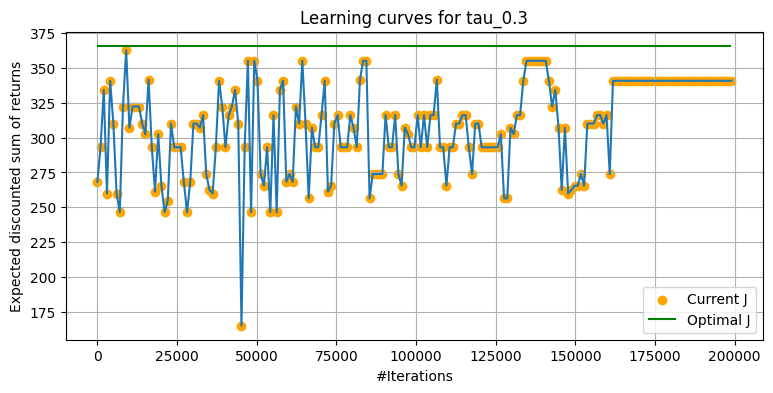

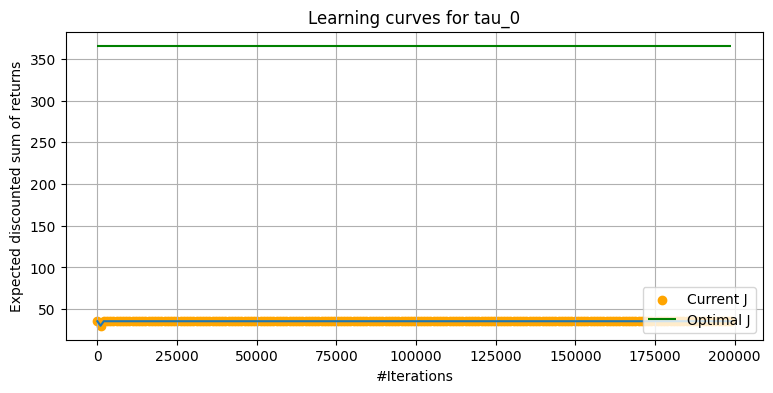

In [6]:
for i, key in enumerate(intermediate_results.keys()):
    status_step = 1000
    xmax = len(intermediate_results[key]['J'])*status_step
    x = np.linspace(0, xmax, num=len(intermediate_results[key]['J']))
    y = intermediate_results[key]['J']
    plt.figure(figsize=(9, 4))
    plt.scatter(x, y, c='orange', label='Current J')
    plt.hlines(y=J_star, xmin=0, xmax=xmax, colors=['green'], label='Optimal J')
    plt.plot(x, y)
    plt.grid(visible=True)
    plt.legend(loc="lower right")
    plt.xlabel('#Iterations')
    plt.ylabel('Expected discounted sum of returns')
    plt.title('Learning curves for '+str(key))

In [7]:
V_star = get_value_function(Q_star)
print(V_star)
print(get_policy(Q_star))

[ 70.0602  96.0085 140.2168 206.8852 305.7323 451.9155 668.0195 987.4689]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [8]:
U_star = get_state_action_nextstate_value_function(tmdp.P_mat, tmdp.reward, tmdp.gamma, Q_star)
print(U_star)

Q_reb = rebuild_Q_from_U(tmdp.P_mat, U_star)
print(np.linalg.norm(Q_star - Q_reb, np.inf))

[[[  68.0542   91.4077  131.1952  191.1967  280.159   411.724   606.2176
    893.722 ]
  [  63.0542   86.4077  126.1952  186.1967  275.159   406.724   601.2176
    888.722 ]]

 [[  63.0542   86.4077  126.1952  186.1967  275.159   406.724   601.2176
    888.722 ]
  [  63.0542   86.4077  126.1952  186.1967  275.159   406.724   601.2176
    888.722 ]]

 [[  63.0542   86.4077  126.1952  186.1967  275.159   406.724   601.2176
    888.722 ]
  [  63.0542   86.4077  126.1952  186.1967  275.159   406.724   601.2176
    888.722 ]]

 [[  63.0542   86.4077  126.1952  186.1967  275.159   406.724   601.2176
    888.722 ]
  [  63.0542   86.4077  126.1952  186.1967  275.159   406.724   601.2176
    888.722 ]]

 [[  63.0542   86.4077  126.1952  186.1967  275.159   406.724   601.2176
    888.722 ]
  [  63.0542   86.4077  126.1952  186.1967  275.159   406.724   601.2176
    888.722 ]]

 [[  63.0542   86.4077  126.1952  186.1967  275.159   406.724   601.2176
    888.722 ]
  [  63.0542   86.4077  126.1952 

In [9]:
A_s_a = get_policy_advantage_function(Q_star)
print(A_s_a)


[[  -2.0061    0.    ]
 [ -32.9544    0.    ]
 [ -53.8092    0.    ]
 [ -80.6901    0.    ]
 [-119.5356    0.    ]
 [-176.7565    0.    ]
 [-261.2955    0.    ]
 [-386.2513    0.    ]]


In [10]:
# Veryfying the expected value of the difference among the two transition models
z = 2*(abs(tmdp.tau - tmdp_0.tau))
for i in range(nS):
    x = np.linalg.norm(tmdp.P_mat_tau[i] - tmdp_0.P_mat_tau[i], 1)
    print("Expected difference among the two transition models {}. Theoretical Upperbound {}".format(x, z))


Expected difference among the two transition models 0.525. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.44999999999999996. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.525. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.39. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.525. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.39. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.525. Theoretical Upperbound 0.6
Expected difference among the two transition models 0.38999999999999996. Theoretical Upperbound 0.6


In [11]:
# Veryfing the L_1 norm of the difference among the gamma discounted state distributions
d_0 = compute_d(tmdp_0.mu, tmdp_0.P_mat_tau, get_policy(Q_star), tmdp_0.gamma)
delta_0 = compute_delta(d_0, get_policy(Q_star))

d = compute_d(tmdp.mu, tmdp.P_mat_tau, get_policy(Q), tmdp.gamma)
delta = compute_delta(d, get_policy(Q))

print(d_0)
print(delta_0)

print(d)
print(delta)

d_0_d = np.linalg.norm(d_0 - d, 1)
upp_bound_d = tmdp.gamma*z/(1-tmdp.gamma)

print("Expected difference among the two gamma discounted state distributions {}. Theoretical Upperbound {}".format(d_0_d, upp_bound_d))


[0.0522 0.0759 0.0921 0.1044 0.1182 0.152  0.2834 0.1219]
[[0.     0.0522]
 [0.     0.0759]
 [0.     0.0921]
 [0.     0.1044]
 [0.     0.1182]
 [0.     0.152 ]
 [0.     0.2834]
 [0.     0.1219]]
[0.2592 0.0788 0.0517 0.0858 0.1133 0.1274 0.1839 0.0999]
[[0.2592 0.    ]
 [0.0788 0.    ]
 [0.0517 0.    ]
 [0.     0.0858]
 [0.     0.1133]
 [0.     0.1274]
 [0.     0.1839]
 [0.     0.0999]]
Expected difference among the two gamma discounted state distributions 0.4197312378496351. Theoretical Upperbound 5.400000000000001


In [12]:
A_s_a_s = get_model_advantage_function(tmdp.P_mat, tmdp.reward, tmdp.gamma, Q_star)
print(A_s_a_s)

[[[ 4.2359e-05  2.3354e+01  6.3141e+01  1.2314e+02  2.1210e+02
    3.4367e+02  5.3816e+02  8.2567e+02]
  [-7.0060e+00  1.6348e+01  5.6135e+01  1.1614e+02  2.0510e+02
    3.3666e+02  5.3116e+02  8.1866e+02]]

 [[ 0.0000e+00  2.3354e+01  6.3141e+01  1.2314e+02  2.1210e+02
    3.4367e+02  5.3816e+02  8.2567e+02]
  [-3.2954e+01 -9.6009e+00  3.0187e+01  9.0188e+01  1.7915e+02
    3.1072e+02  5.0521e+02  7.9271e+02]]

 [[-2.3354e+01  0.0000e+00  3.9787e+01  9.9789e+01  1.8875e+02
    3.2032e+02  5.1481e+02  8.0231e+02]
  [-7.7163e+01 -5.3809e+01 -1.4022e+01  4.5980e+01  1.3494e+02
    2.6651e+02  4.6100e+02  7.4851e+02]]

 [[-6.3141e+01 -3.9787e+01  0.0000e+00  6.0002e+01  1.4896e+02
    2.8053e+02  4.7502e+02  7.6253e+02]
  [-1.4383e+02 -1.2048e+02 -8.0690e+01 -2.0689e+01  6.8274e+01
    1.9984e+02  3.9433e+02  6.8184e+02]]

 [[-1.2314e+02 -9.9789e+01 -6.0002e+01  0.0000e+00  8.8962e+01
    2.2053e+02  4.1502e+02  7.0253e+02]
  [-2.4268e+02 -2.1932e+02 -1.7954e+02 -1.1954e+02 -3.0573e+01
  

In [13]:
# Expected to be 0 at the moment
A_tau_tau_prime = get_relative_model_advantage_function(tmdp.P_mat, tmdp.P_mat, tmdp.reward, tmdp.gamma, Q_star)
print(A_tau_tau_prime)
print(np.linalg.norm(A_tau_tau_prime, np.inf))


[[4.2359e-05 4.1061e-05]
 [0.0000e+00 3.3170e-05]
 [0.0000e+00 3.0129e-05]
 [0.0000e+00 2.7447e-05]
 [0.0000e+00 2.5029e-05]
 [0.0000e+00 2.2832e-05]
 [0.0000e+00 2.0831e-05]
 [0.0000e+00 6.5257e-06]]
8.341940958889182e-05
